In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn

In [3]:
glove=Embeddings('glove-wiki-gigaword-50')
#glove300=Embeddings('glove-wiki-gigaword-300')

Loading glove-wiki-gigaword-50 embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
np.isnan(vectors).any()

False

In [6]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 629972.83it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [7]:
#Gender specific vocabulary:
gender_specific=[]
female_vocab=[]
male_vocab=[]
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific=female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [8]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], [
            'her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [9]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],


}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]


In [10]:
euroam_names = ["Adam", "Alan", "Allison", "Amanda", "Amber", "Andrew", "Anne", "Betsy", "Bobbie-Sue", "Brad", "Brandon", "Brendan", "Brett", "Carrie", "Chip", "Colleen", "Courtney", "Crystal", "Donna", "Ellen", "Emily", "Frank", "Fred", "Geoffrey", "Greg", "Hank", "Harry", "Heather", "Ian", "Jack", "Jay",
                "Jed", "Jill", "Jonathan", "Josh", "Justin", "Katie", "Kristen", "Kristin", "Lauren", "Laurie", "Matthew", "Megan", "Melanie", "Meredith", "Nancy", "Neil", "Neil", "Paul", "Peggy", "Peter", "Rachel", "Roger", "Ryan", "Sara", "Sarah", "Shannon", "Stephanie", "Stephen", "Sue-Ellen", "Todd", "Wendy", "Wilbur"]

africanam_names = ["Aiesha", "Aisha", "Alonzo", "Alphonse", "Darnell", "Deion", "Ebony", "Everol", "Hakim", "Jamal", "Jamel", "Jasmine", "Jermaine", "Jerome", "Kareem", "Keisha", "Kenya", "Lakisha", "Lamar", "Lamont", "Lashandra", "Lashelle", "Latisha", "Latonya", "Latoya", "Lavon", "Lerone", "Leroy", "Lionel", "Malik", "Malika", "Marcellus", "Nichelle", "Percell", "Rasaan", "Rashaun", "Rasheed", "Shaniqua", "Shanise", "Sharise", "Shavonn", "Shereen", "Tameisha", "Tamika", "Tanisha",
                   "Tashika", "Tawanda", "Temeka", "Teretha", "Terrence", "Terryl", "Theo", "Tia", "Torrance", "Tremayne", "Tyree", "Tyrone", "Wardell", "Yolanda", "Yvette"]


In [11]:
#Function to prepare the def_set_lists for the debiasing
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_joined=utils.prepare_def_sets_subspace(def_sets["gender"]+ def_sets["race"])

In [12]:
import itertools

def get_pairs_from_equalizing_sets(def_sets):
    data = {i: v for i, v in enumerate(def_sets)}
    #print(data)
    pairs = []
    for _, values in data.items():
	    #Get all possible combinations of pairs
	    for v1 in values:
		    for v2 in values:
                           s = set([v1, v2])
                           if(len(s) > 1 and not (v1 in pairs and v2 in pairs)):
                                pairs.append([v1, v2])
                      #     if (v1 in pairs or v2 in pairs):
                       #          print(v1,v2)
	#Remove duplicates
    pairs.sort()
    cleaned_pairs=list(k for k, _ in itertools.groupby(pairs))
    return cleaned_pairs

In [13]:
from itertools import product


def get_pairs(p1, p2):
    pairs = set()
    for v1, v2 in product(p1, p2):
        for val1, val2 in product(v1, v2):
            pairs.add((val1, val2))
    return list(pairs)


In [14]:
equalizing_lists['race']=get_pairs_from_equalizing_sets(def_sets['race'])


In [15]:
equalizing_lists['intersection']=get_pairs(def_sets['gender'], def_sets['race'])


#### Gender

In [16]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


#### Joint

In [ ]:
deb_vect_joined, deb_vocab_joined, deb_word2idx_joined, deb_dict_joined = hard_debias(vectors,
                                                                            dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['intersection'],
                                                                              def_set_joined,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


## Evaluation

In [17]:
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd

### Gender Bias Pre-Post

In [18]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

In [19]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)


Length of vectors set: 22
Running PCA with 1 components


In [20]:
gender_bias_original2 = compute_direct_bias(
    dict_vectors, vocab_cleaned, gender_direction)


In [21]:
compute_average_bias(deb_dict_gender, neutral_words, gender_direction)


4.175328711814019e-08

In [22]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, gender_direction)


In [23]:
gender_bias_after_debiasing=compute_gender_simple_bias(deb_dict_gender, he_embed, she_embed)

In [24]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [25]:
bias_df=get_bias_score_df_from_list(gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,deb_vocab_gender)
plot_bias_bar(bias_df, "Gender bias on occupations (original vs debiased)", "Occupations")

In [26]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 0.0


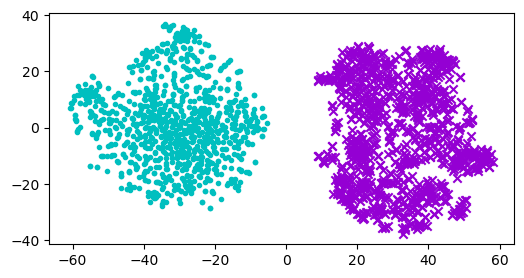

In [27]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 0.713


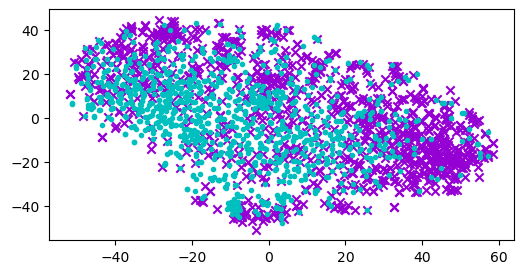

In [28]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, deb_vect_gender, deb_word2idx_gender)

cluster_and_visualize(male_words + female_words, gendered_debiased_vectors,
                      'Debiased_GloVe', y_true)


###  Random Words: bias scores and neighbors

In [29]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3


In [30]:
random_words

array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland', 'withdrawn', 'parole', 'listened', 'rugby',
       'garbage', 'fears', 'neighboring', 'personalities', 'deceased',
       'political', 'concluded', 'operate', 'reflected', 'controlled',
       'symbols', 'session', 'female', 'revolutionary', 'consensus',
       'roc', 'albania', 'carpet', 'evaluate', 'destinations', 'colombia',
       'physicians', 'lobbyists', 'travels', 'laura', 'loyalty'],
      dtype='<U18')

In [31]:
#Getting the gender bias score for the random words list
bias_df = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df, "Gender bias on random_words (original vs debiased)", "Random_words")


In [32]:
#Sanity checks
#Gensim's .most_similar() method finds the top-N most similar words to a given word.
#See documentation: https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
glove.model.most_similar(random_words[0], topn=10)
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)
model_original.most_similar(random_words[0], topn=3)


[('cloud', 0.8214010000228882),
 ('mist', 0.7935919761657715),
 ('dust', 0.7828845977783203)]

In [33]:
from tqdm import tqdm
#Function to find the top-k most similar words to a given word using the cosine similarity
def topK(word, dict_vect, vocab, vectors, w2i, k=10):
    k_neigh ={}
    list_neigh = []
    # extract the word vector for word w
    idx = w2i[word]
    chosen_vec = dict_vect[word]
    
    # compute cosine similarity between chosen_vec and all other words. Store in similarities list
    similarities = np.zeros(len(vocab))
    for i in range(len(vocab)):
        similarities[i] = cosine_similarity(chosen_vec, vectors[i])
    #similarities =[cosine_similarity(vectors.dot(chosen_vec)
    # sort similarities by descending order
    sorted_similarities = (similarities.argsort())[::-1]

    # choose topK
    best = sorted_similarities[:(k+1)]

    #create a list with the word and similarity score for each of the topK words
    k_neig_similarities = [(vocab[i], similarities[i]) for i in best if i!=idx]
    k_neigh[word]= k_neig_similarities
    list_neigh=[vocab[i] for i in best if i != idx]
    return k_neigh, list_neigh


In [34]:
topK(random_words[0], dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=10)


({'clouds': [('cloud', 0.8214010860640797),
   ('mist', 0.7935920116111957),
   ('dust', 0.782884530184965),
   ('fog', 0.7676070760284758),
   ('icy', 0.7551351920048492),
   ('billowing', 0.7550188078252074),
   ('sunlight', 0.7484487037893831),
   ('swirling', 0.7462892524536663),
   ('plumes', 0.7420431465215314),
   ('lava', 0.7243867546220458)]},
 ['cloud',
  'mist',
  'dust',
  'fog',
  'icy',
  'billowing',
  'sunlight',
  'swirling',
  'plumes',
  'lava'])

In [35]:
#get a dictionary with all the k-nearest neighbors for each word in the list
def get_k_nearest_neighbors(list_words, dict_vect, vocab, vectors, w2i, k=10):
    k_neigh ={}
    for w in tqdm(list_words):
        dict_neigh, _ = topK(w, dict_vect, vocab, vectors, w2i, k)
        k_neigh.update(dict_neigh)
    return k_neigh

In [36]:
k_neigh= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


In [37]:
#get a list of the neighbors for each word of the dictionary k_neigh
def get_list_neighbors(k_neigh):
    list_neigh = []
    for w in k_neigh.keys():
        list_neigh.append([i[0] for i in k_neigh[w]])
    return list_neigh

In [38]:
list_neigh = get_list_neighbors(k_neigh)

In [39]:
#function to get the frequency of the original neighbors among the 50 nearest neighbors of selected words
def get_frequency_original_neighbors(list_words, list_neigh, dict_vect_debiased, vocab_debiased, vectors_debiased, w2i_debiased, neighbours_num=50):

    scores = []
    for idx,word in tqdm(enumerate(list_words)):

        _, top = topK(word, dict_vect_debiased, vocab_debiased, vectors_debiased, w2i_debiased,
                   k=neighbours_num)

        count = 0
        
        for t in top:
            if t in list_neigh[idx]:
                print(t)
                count += 1
            

        scores.append([word, count, count/neighbours_num])
        #print(top)
    return scores


In [40]:
neig_freq2=get_frequency_original_neighbors(
    random_words, list_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


1it [00:01,  1.51s/it]

surface


7it [00:10,  1.48s/it]

important


12it [00:17,  1.49s/it]

everything


19it [00:28,  1.48s/it]

passengers
policemen


20it [00:29,  1.49s/it]

minnesota


34it [00:50,  1.48s/it]

effectively


36it [00:53,  1.48s/it]

week


37it [00:54,  1.48s/it]

male


41it [01:00,  1.48s/it]

croatia
yugoslavia


48it [01:11,  1.48s/it]

away


49it [01:12,  1.48s/it]

anna


50it [01:14,  1.48s/it]


In [41]:
df = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])


In [42]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq':'Proportion', 'word':'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()

In [43]:
#Getting the neighbors of debiased vectors the Gensim way
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 50)
finding_neighbors_before_after(random_words, model_original, gender_debiased, topn=50)

----------------------------------
word: clouds
 most-similar-before: ('cloud', 'mist', 'dust', 'fog', 'icy', 'billowing', 'sunlight', 'swirling', 'plumes', 'lava', 'skies', 'shadows', 'smoke', 'glow', 'ash', 'vents', 'snow', 'waves', 'temperatures', 'breeze', 'volcanic', 'sky', 'drifting', 'surface', 'beneath', 'tides', 'horizon', 'showers', 'swirl', 'tide', 'frigid', 'noctilucent', 'cooler', 'darkness', 'moisture', 'dark', 'faint', 'enveloped', 'shrouded', 'disturbance', 'thunderstorms', 'visible', 'winds', 'currents', 'ocean', 'dense', 'chill', 'rain', 'light', 'billowed')
 most-similar-after: ('dprk', 'longtime', 'mps', 'probe', 'sponsors', 'gained', 'hong', 'alike', 'morgan', 'arresting', 'tougher', 'encephalitis', 'quotes', 'subsequently', 'sars', 'southern', 'lobby', 'draft', 'slate', 'medium', 'facts', 'basement', 'sammy', 'targets', 'marker', 'chorus', 'hoisted', 'ka', 'da', 'acres', 'ink', 'grain', 'sterling', 'cathedral', 'substandard', 'strategy', 'clothing', 'surface', 'jo

defaultdict(dict,
            {'clouds': {'before': ('cloud',
               'mist',
               'dust',
               'fog',
               'icy',
               'billowing',
               'sunlight',
               'swirling',
               'plumes',
               'lava',
               'skies',
               'shadows',
               'smoke',
               'glow',
               'ash',
               'vents',
               'snow',
               'waves',
               'temperatures',
               'breeze',
               'volcanic',
               'sky',
               'drifting',
               'surface',
               'beneath',
               'tides',
               'horizon',
               'showers',
               'swirl',
               'tide',
               'frigid',
               'noctilucent',
               'cooler',
               'darkness',
               'moisture',
               'dark',
               'faint',
               'enveloped',
            

In [44]:
k_neigh= get_k_nearest_neighbors(random_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50)

100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


In [45]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, gender_debiased, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


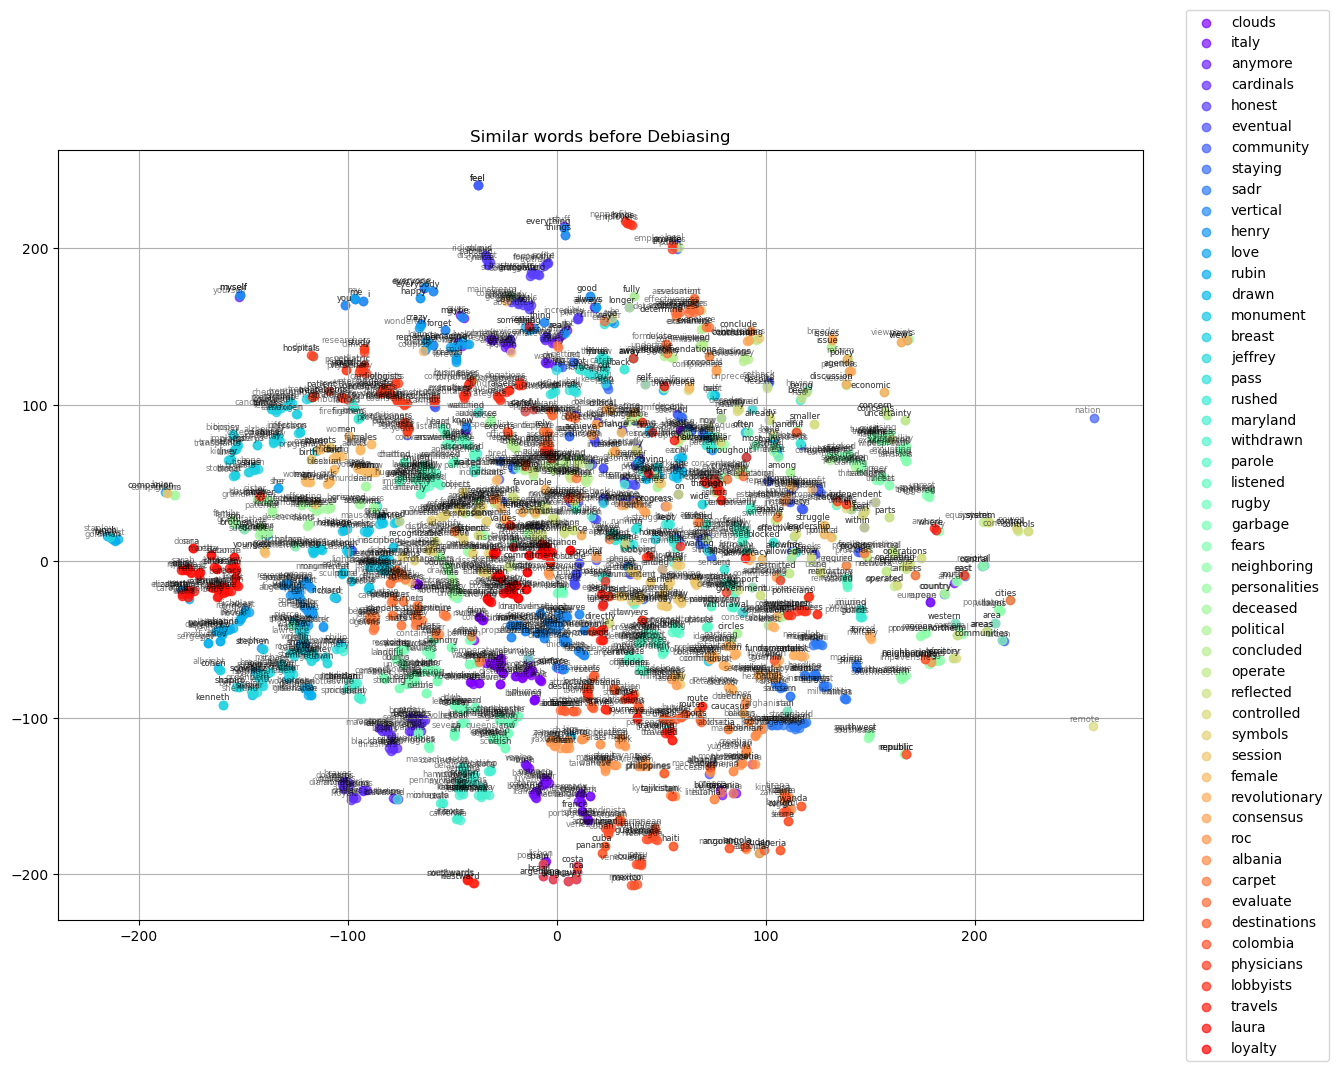

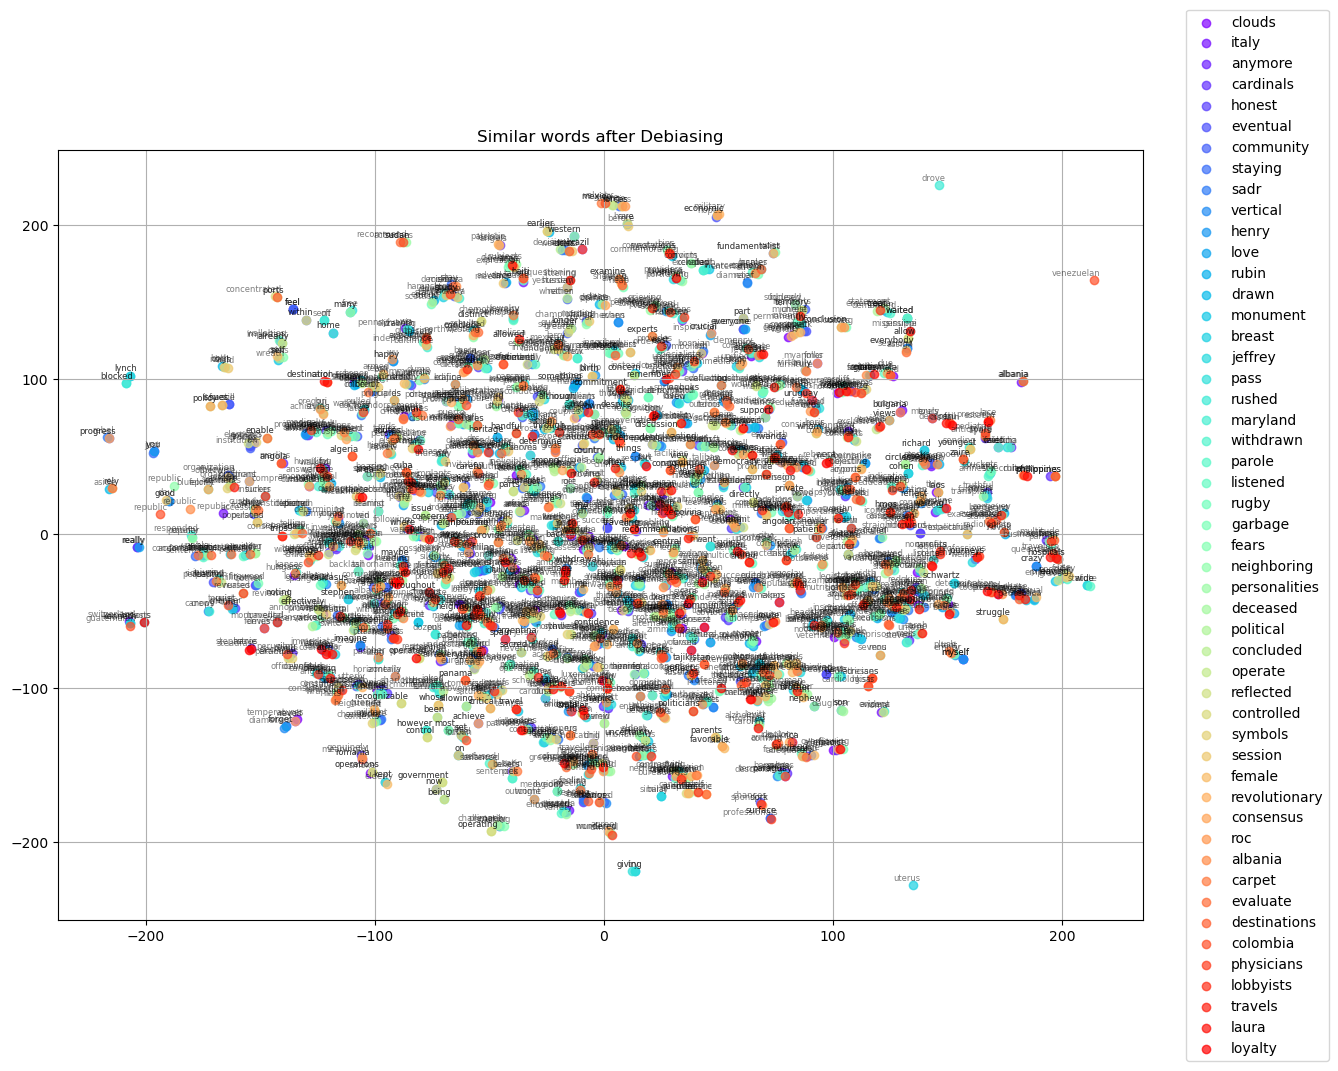

In [46]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [47]:
#Create a function to get the average distance of the neighbors of a word from the word itself
def gettng_neighbor_av_distance(word, neighbors, vectors, word2idx):
    distances = []
    for n in neighbors:
        distances.append(np.linalg.norm(vectors[word2idx[word]] - vectors[word2idx[n]]))
    return np.mean(distances)


In [48]:
#Create a function to get the average distance of the neighbors of a word in the debiased embeddings to their possition in the original embeddings
def getting_neighbor_av_distance_debiased(word, neighbors, dict_vectors, debiased_dict):
    distances = []
    for n in neighbors:
        distances.append(cosine_similarity(debiased_dict[n], dict_vectors[n]))
    return np.mean(distances) 

In [49]:
#getting average cosine distance to neighbors before and after debiasing
def get_distance_to_neighbors(random_words, list_neigh, dict_vectors, debiased_dict):
    distances_original = {}
    distances_debiased = {}
    for i,word in enumerate(random_words):
        dist1=[]
        dist2=[]
        for neigh in list_neigh[i]:
            dist1.append([neigh, 1-cosine_similarity(dict_vectors[word], dict_vectors[neigh])])
            dist2.append([neigh, 1-cosine_similarity(debiased_dict[word], debiased_dict[neigh])])

        distances_original[word] = dist1
        distances_debiased[word] = dist2    
    
    return distances_original,distances_debiased

In [50]:
distances_original,distances_debiased=get_distance_to_neighbors(random_words, list_neigh,
                          dict_vec_cleaned, deb_dict_gender)


In [51]:
#get dataframe of distances from distances_original and distances_debiased
def get_df_distances(distances_original,distances_debiased):
    df=pd.DataFrame()
    for word in distances_original.keys():
        for i in range(len(distances_original[word])):
            #df=df.append({'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}, ignore_index=True)
            df=pd.concat([df, pd.DataFrame.from_records([{'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}])], ignore_index=True)
            
    return df

In [52]:
df_neigh_distances=get_df_distances(distances_original,distances_debiased)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])

df_average=df_average.sort_values(by='difference', ascending=True)
df_average=df_average.rename(columns={'distance_original':'average distance to neighbors (original embeddings)', 'distance_debiased':'average distance to neighbors (debiased embeddings)'})

In [53]:
df_average


,average distance to neighbors (original embeddings),average distance to neighbors (debiased embeddings),difference
word,,,
controlled,0.296785,0.535264,0.238478
political,0.248785,0.488006,0.239221
community,0.283020,0.560597,0.277577
session,0.287781,0.567151,0.279370
travels,0.386745,0.702822,0.316077
neighboring,0.240127,0.557127,0.317000
rugby,0.290741,0.662426,0.371685
love,0.217053,0.590501,0.373448
drawn,0.254046,0.628974,0.374928


In [54]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_average.index, y=df_average['average distance to neighbors (original embeddings)'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_average.index, y=df_average['average distance to neighbors (debiased embeddings)'], name='Debiased Embeddings'))
#add title
fig.update_layout(title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()

In [71]:
race_direction = identify_bias_subspace(
    deb_dict_gender, def_set_race, 1, centralizing=True)

Length of vectors set: 19
Running PCA with 1 components


In [72]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, race_direction)


### Name Analysis

In [ ]:
names_white= list(w.lower() for w in names_ethnicity['White'] if w.lower() in set(vocab_cleaned))
names_black= list(w.lower() for w in names_ethnicity['Black'] if w.lower() in set(vocab_cleaned))
names_latino= list(w.lower() for w in names_ethnicity['Hispanic'] if w.lower() in set(vocab_cleaned))
#euroam_names_emb= list(w for w in euroam_names if w in set(vocab_cleaned))

In [ ]:
bias_df_names = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, names_black, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df_names, "Gender bias on english names (original vs debiased)", "Names")

In [ ]:
k_neigh= get_k_nearest_neighbors(names_black[:17], dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

In [ ]:
k_neigh

In [ ]:
list_neigh = get_list_neighbors(k_neigh)


In [ ]:
get_frequency_original_neighbors(
    names_black[:17], list_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


In [ ]:
model_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 50)


In [ ]:
gendered_words_before_and_after=finding_neighbors_before_after(names_black, model_original, model_debiased, topn=50)

In [ ]:
keys2=names_black
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing', keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
# get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)

def bias_by_neighbors(dict_vect, vocab, vectors, w2i, neighbours_num=100):

    tuples = []
    for word in tqdm(vocab):

        _, top = topK(word, dict_vect, vocab, vectors, w2i,
                      k=neighbours_num+5)

        m = 0
        f = 0
        for t in top:
            if gender_bias_original[t] < 0:
                m += 1
            else:
                f += 1

        tuples.append(
            (word, gender_bias_original[word], gender_bias_after_debiasing[word], m, f))

    return tuples


bias_by_neighbors(dict_vec_cleaned, vocab_cleaned,
                  vectors_cleaned, word2idx_cleaned, neighbours_num=50)

gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole",
                  "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
# "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after = finding_neighbors_before_after(
    gendered_names, model_original, model_debiased, topn=3)
keys2 = gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing',
                        keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


### MAC Scores

In [ ]:
targets = [["he", "she"],
            ["his", "hers"],
            ["son", "daughter"],
            ["father", "mother"],
            ["male", "female"],
            ["boy", "girl"],
            ["uncle", "aunt"]]

Attribtutes = [["manager", "executive", "doctor", "lawyer", "programmer", "scientist",
                "soldier", "supervisor", "rancher", "janitor", "firefighter", "officer"], ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", "receptionist", "counselor"]]


In [ ]:
debiasedMAC, debiasedDistribution=multiclass_evaluation_MAC(
    debiased_dict, targets, Attribtutes)

originalMAC,originalDistribution = multiclass_evaluation_MAC(
    dict_vec_cleaned, targets, Attribtutes)


In [ ]:
from scipy.stats import ttest_rel, spearmanr
statistics, pvalue = ttest_rel(originalDistribution, debiasedDistribution)


### Bias by neighbor

In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)


In [ ]:
biased_words=female_words+male_words

In [ ]:


k_neighbors=finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)


In [ ]:
#take k_neighbors dictionary and

In [ ]:
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)

#### Race

In [ ]:

deb_vect_race, deb_vocab_race, deb_word2idx_race, deb_dict_race = hard_debias(vectors,
                                                                              dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['race'],
                                                                              def_set_race,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


In [ ]:
neig_freq_race= get_frequency_original_neighbors(
    random_words, list_neigh, deb_dict_race, deb_vocab_race, deb_vect_race, deb_word2idx_race, neighbours_num=50)


In [ ]:
pd.DataFrame(neig_freq_race, columns=['word', 'previous_neighbours', 'freq'])

In [ ]:
## Finding race Debiased Words.
race_debiased = create_KeyedVectors(deb_vect_race, deb_vocab_race, 50)
finding_neighbors_before_after(random_words, model_original, race_debiased, topn=3)
joined_debiased = create_KeyedVectors(deb_vect_joined, deb_vocab_joined, 50)
finding_neighbors_before_after(
    random_words, model_original, joined_debiased, topn=2)


### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")



## INLP

In [55]:
from Scripts.INLP import *


In [56]:
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 50)


In [57]:
num_vectors_per_class = 7500

gender_direction = identify_bias_subspace(
    dict_vec_cleaned, def_set_gender, 1, centralizing=False)
gender_direction = np.squeeze(gender_direction)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
fem_words_and_scores, masc_words_and_scores, neut_words_and_scores = getting_classes_for_INLP(
    gender_vector=gender_direction, model=model_original, n=7500)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

#getting the vectors corresponding to masc_words from the dict_vec_cleaned
masc_vecs = [vector for word, vector in dict_vec_cleaned.items()
             if word in masc_words]
fem_vecs = [vector for word, vector in dict_vec_cleaned.items()
            if word in fem_words]
neut_vecs = [vector for word, vector in dict_vec_cleaned.items()
             if word in neut_words]

#turn the list of vectors into a numpy array
masc_vecs = np.array(masc_vecs)
fem_vecs = np.array(fem_vecs)
neut_vecs = np.array(neut_vecs)

#masc_vecs, fem_vecs = model_original.get_vectors_from_list(masc_words), model_original.get_vectors_from_list(fem_words)
#neut_vecs = model_original.get_vectors_from_list(neut_words)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs = np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.zeros(n, dtype=int),
                                                  np.ones(n, dtype=int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
    all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC:", masc_words[:50])
print("-------------------------")
print("TOP FEM:", fem_words[:50])
print("-------------------------")
print("Random Neutral:", neut_words[:50])


Length of vectors set: 11
Running PCA with 1 components
TOP MASC: ('lovely', 'comfortable', 'feels', 'beautiful', 'looks', 'pretty', 'wonderful', 'herself', 'everyone', 'happy', 'looked', 'mary', 'mom', 'hers', 'lucky', 'loved', 'lisa', 'reminds', 'happily', 'loves', 'gorgeous', 'feel', 'liked', 'comfort', 'finds', 'alice', 'loving', 'remembers', 'look', 'everybody', 'fit', 'her', 'happier', 'charming', 'guy', 'likes', 'nice', 'quite', 'julie', 'laura', 'lauren', 'lonely', 'perfectly', 'really', 'seeing', 'uncomfortable', 'ellen', 'miss', 'oddly', 'walking')
-------------------------
TOP FEM: ('lmi', 'jcd', 'bcl', 'tnsm', 'wfi', 'palipehutu', 'gam', 'hukbalahap', 'aas', 'msi', 'ican', 'isocyanate', 'mada', 'möhne', 'liviu', 'nscn', 'ikhwan', 'jdo', 'ambo', 'asala', 'uamsho', 'huji', 'rra', 'mgb', 'btc', 'houthis', 'icmi', 'kdpi', 'gadjah', 'mirwaiz', 'polybrominated', 'aumf', 'uom', 'doku', 'epr', 'cft', 'pki', 'bw', 'biu', 'hizb', 'ypa', 'hiti', 'khaplang', 'kyparissia', 'csg', 'ysp',

In [58]:
#random.seed(42)
#np.random.seed(42)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis=0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype=int)
y_fem = np.zeros(fem_vecs.shape[0], dtype=int)
y_neut = -np.ones(neut_vecs.shape[0], dtype=int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(
    X_train_dev, y_train_dev, test_size=0.3, random_state=42)
print("Train size: {}; Dev size: {}; Test size: {}".format(
    X_train.shape[0], X_dev.shape[0], X_test.shape[0]))


Train size: 10685; Dev size: 4580; Test size: 6543


In [59]:
from sklearn.svm import LinearSVC, SVC
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'penalty': 'l2', 'fit_intercept': False,
              'class_weight': None, "dual": False, 'random_state': 42}
params_sgd = {'penalty': 'l2', 'fit_intercept': False,
              'class_weight': None, 'max_iter': 1000, 'random_state': 42}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
dropout_rate = 0


In [60]:
P, rowspace_projs, Ws = get_debiasing_projection(gender_clf, params, n, 50, min_acc,
                                                 X_train, Y_train, X_dev, Y_dev,
                                                 is_autoregressive=True, Y_train_main=None, Y_dev_main=None,
                                                 dropout_rate=0)


iteration: 34, accuracy: 0.3168122270742358: 100%|██████████| 35/35 [00:01<00:00, 25.64it/s] 


In [61]:
inlp_vectors = (P.dot(vectors_cleaned.T)).T
inlp_dict = get_debiased_dict(inlp_vectors, word2idx_cleaned)
inlp_vocab = list(inlp_dict.keys())


In [62]:
inlp_freq=get_frequency_original_neighbors(
    random_words, list_neigh, inlp_dict, inlp_vocab, inlp_vectors, word2idx_cleaned, neighbours_num=50)


1it [00:01,  1.83s/it]

cloud
rain
noctilucent
fog
darkness
mist
billowing


3it [00:05,  1.80s/it]

pretend
do
else
anybody


4it [00:07,  1.80s/it]

sabres


6it [00:10,  1.79s/it]

achieved


8it [00:14,  1.79s/it]

stayed


9it [00:16,  1.79s/it]

mahdi
shiite
moqtada
muqtada
fatah
sunni
islamists
militia
islamist


12it [00:21,  1.80s/it]

dreams


15it [00:26,  1.79s/it]

statue


17it [00:30,  1.79s/it]

roger


19it [00:34,  1.79s/it]

paramedics
panicked
ambulance
responded
ambulances


22it [00:39,  1.79s/it]

prison
reinstated
incarcerated
prosecuted


23it [00:41,  1.80s/it]

aloud
attentively


24it [00:43,  1.80s/it]

geelong
springbok
wallabies


25it [00:44,  1.80s/it]

heap
cans
trash
bins
heaps


26it [00:46,  1.80s/it]

blaming


31it [00:55,  1.80s/it]

investigations
examining


32it [00:57,  1.80s/it]

operated


33it [00:59,  1.80s/it]

reflecting
reflects


35it [01:02,  1.80s/it]

depictions
depict
numerals
denote


36it [01:04,  1.80s/it]

opening


37it [01:06,  1.79s/it]

male


39it [01:09,  1.78s/it]

objectives


41it [01:13,  1.78s/it]

macedonia


42it [01:15,  1.77s/it]

drapes


44it [01:18,  1.78s/it]

itineraries
hubs


45it [01:20,  1.78s/it]

ecuador


46it [01:22,  1.78s/it]

dentists
patients
doctors


47it [01:24,  1.79s/it]

lobbied
lobbyist
corporations


48it [01:26,  1.78s/it]

southwards
westwards


50it [01:29,  1.79s/it]


In [65]:
inlp_freq

[['clouds', 7, 0.14],
 ['italy', 0, 0.0],
 ['anymore', 4, 0.08],
 ['cardinals', 1, 0.02],
 ['honest', 0, 0.0],
 ['eventual', 1, 0.02],
 ['community', 0, 0.0],
 ['staying', 1, 0.02],
 ['sadr', 9, 0.18],
 ['vertical', 0, 0.0],
 ['henry', 0, 0.0],
 ['love', 1, 0.02],
 ['rubin', 0, 0.0],
 ['drawn', 0, 0.0],
 ['monument', 1, 0.02],
 ['breast', 0, 0.0],
 ['jeffrey', 1, 0.02],
 ['pass', 0, 0.0],
 ['rushed', 5, 0.1],
 ['maryland', 0, 0.0],
 ['withdrawn', 0, 0.0],
 ['parole', 4, 0.08],
 ['listened', 2, 0.04],
 ['rugby', 3, 0.06],
 ['garbage', 5, 0.1],
 ['fears', 1, 0.02],
 ['neighboring', 0, 0.0],
 ['personalities', 0, 0.0],
 ['deceased', 0, 0.0],
 ['political', 0, 0.0],
 ['concluded', 2, 0.04],
 ['operate', 1, 0.02],
 ['reflected', 2, 0.04],
 ['controlled', 0, 0.0],
 ['symbols', 4, 0.08],
 ['session', 1, 0.02],
 ['female', 1, 0.02],
 ['revolutionary', 0, 0.0],
 ['consensus', 1, 0.02],
 ['roc', 0, 0.0],
 ['albania', 1, 0.02],
 ['carpet', 1, 0.02],
 ['evaluate', 0, 0.0],
 ['destinations', 2, 0.0

In [66]:
import plotly_express as px
df2=pd.DataFrame(inlp_freq, columns=['word', 'previous_neighbours', 'freq'])

#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df2, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased network',
             labels={'freq': 'Proportion', 'word': 'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()


In [67]:
distances_original_inlp, distances_debiased_inlp = get_distance_to_neighbors(random_words, list_neigh,
                                                                   dict_vec_cleaned, inlp_dict)


In [73]:
bias_df3 = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df3, "Gender bias on occupations (original vs debiased)", "Occupations")


## Testing Bias Direction from Scratch

In [ ]:
gender_dir=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)


In [ ]:
gender_dir = np.squeeze(gender_dir)
gender_dir


In [ ]:
race_dir=identify_bias_subspace(dict_vec_cleaned, def_set_race, 1, centralizing=True)


In [ ]:
race_dir = np.squeeze(race_dir)
race_dir


In [ ]:
wv_gender=neutralize_words(vocab_cleaned, vectors, word2idx_cleaned, gender_dir)
wv_gender

In [ ]:
equalize_words(wv_gender, vocab_cleaned, word2idx_cleaned,
               equalizing_lists['gender'], gender_dir)


In [ ]:
wv_race=neutralize_words(vocab_cleaned, vectors, word2idx_cleaned, race_dir)
wv_race

In [ ]:
equalize_words(wv_race, vocab_cleaned, word2idx_cleaned,
               equalizing_lists['race'], race_dir)


In [ ]:
wv_race.shape

In [ ]:
gender_dict=get_debiased_dict(wv_gender, word2idx_cleaned)

In [ ]:
race_dict=get_debiased_dict(wv_race, word2idx_cleaned)

In [ ]:
len(word2idx_cleaned)

In [ ]:
k_gender= get_k_nearest_neighbors(random_words, gender_dict, list(gender_dict.keys()), wv_gender, word2idx_cleaned, k=50)

In [ ]:
k_race= get_k_nearest_neighbors(random_words, race_dict, list(race_dict.keys()), wv_race, word2idx_cleaned, k=50)

In [ ]:
k_gender[random_words[0]]

In [ ]:
k_race[random_words[0]]==k_gender[random_words[0]]

In [ ]:
#get the first element of each tuple in the list k_race[random_words[0]]
first_race=[k_race[random_words[0]][i][0] for i in range(len(k_race[random_words[0]]))]
first_gender = [k_gender[random_words[0]][i][0]
              for i in range(len(k_gender[random_words[0]]))]



In [ ]:
[first_race[i]==first_gender[i] for i in range(len(first_gender))]

In [ ]:
gen_freq = get_frequency_original_networks(
    random_words, list_neigh, gender_dict, list(gender_dict.keys()), wv_gender, word2idx_cleaned, neighbours_num=50)


In [ ]:
race_freq = get_frequency_original_networks(
    random_words, list_neigh, race_dict, list(race_dict.keys()), wv_race, word2idx_cleaned, neighbours_num=50)


In [ ]:
gen_freq==race_freq